<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [The Basics of NumPy Arrays](02.02-The-Basics-Of-NumPy-Arrays.ipynb) | [Contents](Index.ipynb) | [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.03-Computation-on-arrays-ufuncs.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Computation on NumPy Arrays: Universal Functions

Up until now, we have been discussing some of the basic nuts and bolts of NumPy; in the next few sections, we will dive into the reasons that NumPy is so important in the Python data science world.
Namely, it provides an easy and flexible interface to optimized computation with arrays of data.

Computation on NumPy arrays can be very fast, or it can be very slow.
The key to making it fast is to use *vectorized* operations, generally implemented through NumPy's *universal functions* (ufuncs).
This section motivates the need for NumPy's ufuncs, which can be used to make repeated calculations on array elements much more efficient.
It then introduces many of the most common and useful arithmetic ufuncs available in the NumPy package.

## The Slowness of Loops

Python's default implementation (known as CPython) does some operations very slowly.
This is in part due to the dynamic, interpreted nature of the language: the fact that types are flexible, so that sequences of operations cannot be compiled down to efficient machine code as in languages like C and Fortran.
Recently there have been various attempts to address this weakness: well-known examples are the [PyPy](http://pypy.org/) project, a just-in-time compiled implementation of Python; the [Cython](http://cython.org) project, which converts Python code to compilable C code; and the [Numba](http://numba.pydata.org/) project, which converts snippets of Python code to fast LLVM bytecode.
Each of these has its strengths and weaknesses, but it is safe to say that none of the three approaches has yet surpassed the reach and popularity of the standard CPython engine.

The relative sluggishness of Python generally manifests itself in situations where many small operations are being repeated – for instance looping over arrays to operate on each element.
For example, imagine we have an array of values and we'd like to compute the reciprocal of each.
A straightforward approach might look like this:

In [1]:
import numpy as np
np.random.seed(0)

def compute_reciprocals(values):
    output = np.empty(len(values))
    for i in range(len(values)):
        output[i] = 1.0 / values[i]
    return output
        
values = np.random.randint(1, 10, size=5)
compute_reciprocals(values)

array([ 0.16666667,  1.        ,  0.25      ,  0.25      ,  0.125     ])

This implementation probably feels fairly natural to someone from, say, a C or Java background.
But if we measure the execution time of this code for a large input, we see that this operation is very slow, perhaps surprisingly so!
We'll benchmark this with IPython's ``%timeit`` magic (discussed in [Profiling and Timing Code](01.07-Timing-and-Profiling.ipynb)):

In [2]:
big_array = np.random.randint(1, 100, size=1000000)
%timeit compute_reciprocals(big_array)

1 loop, best of 3: 2.91 s per loop


It takes several seconds to compute these million operations and to store the result!
When even cell phones have processing speeds measured in Giga-FLOPS (i.e., billions of numerical operations per second), this seems almost absurdly slow.
It turns out that the bottleneck here is not the operations themselves, but the type-checking and function dispatches that CPython must do at each cycle of the loop.
Each time the reciprocal is computed, Python first examines the object's type and does a dynamic lookup of the correct function to use for that type.
If we were working in compiled code instead, this type specification would be known before the code executes and the result could be computed much more efficiently.

## Introducing UFuncs

For many types of operations, NumPy provides a convenient interface into just this kind of statically typed, compiled routine. This is known as a *vectorized* operation.
This can be accomplished by simply performing an operation on the array, which will then be applied to each element.
This vectorized approach is designed to push the loop into the compiled layer that underlies NumPy, leading to much faster execution.

Compare the results of the following two:

In [3]:
print(compute_reciprocals(values))
print(1.0 / values)

[ 0.16666667  1.          0.25        0.25        0.125     ]
[ 0.16666667  1.          0.25        0.25        0.125     ]


Looking at the execution time for our big array, we see that it completes orders of magnitude faster than the Python loop:

In [4]:
%timeit (1.0 / big_array)

100 loops, best of 3: 4.6 ms per loop


Vectorized operations in NumPy are implemented via *ufuncs*, whose main purpose is to quickly execute repeated operations on values in NumPy arrays.
Ufuncs are extremely flexible – before we saw an operation between a scalar and an array, but we can also operate between two arrays:

In [5]:
np.arange(5) / np.arange(1, 6)

array([ 0.        ,  0.5       ,  0.66666667,  0.75      ,  0.8       ])

And ufunc operations are not limited to one-dimensional arrays–they can also act on multi-dimensional arrays as well:

In [6]:
x = np.arange(9).reshape((3, 3))
2 ** x

array([[  1,   2,   4],
       [  8,  16,  32],
       [ 64, 128, 256]])

Computations using vectorization through ufuncs are nearly always more efficient than their counterpart implemented using Python loops, especially as the arrays grow in size.
Any time you see such a loop in a Python script, you should consider whether it can be replaced with a vectorized expression.

## Exploring NumPy's UFuncs

Ufuncs exist in two flavors: *unary ufuncs*, which operate on a single input, and *binary ufuncs*, which operate on two inputs.
We'll see examples of both these types of functions here.

### Array arithmetic

NumPy's ufuncs feel very natural to use because they make use of Python's native arithmetic operators.
The standard addition, subtraction, multiplication, and division can all be used:

In [7]:
x = np.arange(4)
print("x     =", x)
print("x + 5 =", x + 5)
print("x - 5 =", x - 5)
print("x * 2 =", x * 2)
print("x / 2 =", x / 2)
print("x // 2 =", x // 2)  # floor division

x     = [0 1 2 3]
x + 5 = [5 6 7 8]
x - 5 = [-5 -4 -3 -2]
x * 2 = [0 2 4 6]
x / 2 = [ 0.   0.5  1.   1.5]
x // 2 = [0 0 1 1]


There is also a unary ufunc for negation, and a ``**`` operator for exponentiation, and a ``%`` operator for modulus:

In [8]:
print("-x     = ", -x)
print("x ** 2 = ", x ** 2)
print("x % 2  = ", x % 2)

-x     =  [ 0 -1 -2 -3]
x ** 2 =  [0 1 4 9]
x % 2  =  [0 1 0 1]


In addition, these can be strung together however you wish, and the standard order of operations is respected:

In [9]:
-(0.5*x + 1) ** 2

array([-1.  , -2.25, -4.  , -6.25])

Each of these arithmetic operations are simply convenient wrappers around specific functions built into NumPy; for example, the ``+`` operator is a wrapper for the ``add`` function:

In [10]:
np.add(x, 2)

array([2, 3, 4, 5])

The following table lists the arithmetic operators implemented in NumPy:

| Operator	    | Equivalent ufunc    | Description                           |
|---------------|---------------------|---------------------------------------|
|``+``          |``np.add``           |Addition (e.g., ``1 + 1 = 2``)         |
|``-``          |``np.subtract``      |Subtraction (e.g., ``3 - 2 = 1``)      |
|``-``          |``np.negative``      |Unary negation (e.g., ``-2``)          |
|``*``          |``np.multiply``      |Multiplication (e.g., ``2 * 3 = 6``)   |
|``/``          |``np.divide``        |Division (e.g., ``3 / 2 = 1.5``)       |
|``//``         |``np.floor_divide``  |Floor division (e.g., ``3 // 2 = 1``)  |
|``**``         |``np.power``         |Exponentiation (e.g., ``2 ** 3 = 8``)  |
|``%``          |``np.mod``           |Modulus/remainder (e.g., ``9 % 4 = 1``)|

Additionally there are Boolean/bitwise operators; we will explore these in [Comparisons, Masks, and Boolean Logic](02.06-Boolean-Arrays-and-Masks.ipynb).

### Absolute value

Just as NumPy understands Python's built-in arithmetic operators, it also understands Python's built-in absolute value function:

In [11]:
x = np.array([-2, -1, 0, 1, 2])
abs(x)

array([2, 1, 0, 1, 2])

The corresponding NumPy ufunc is ``np.absolute``, which is also available under the alias ``np.abs``:

In [12]:
np.absolute(x)

array([2, 1, 0, 1, 2])

In [13]:
np.abs(x)

array([2, 1, 0, 1, 2])

This ufunc can also handle complex data, in which the absolute value returns the magnitude:

In [14]:
x = np.array([3 - 4j, 4 - 3j, 2 + 0j, 0 + 1j])
np.abs(x)

array([ 5.,  5.,  2.,  1.])

### Trigonometric functions

NumPy provides a large number of useful ufuncs, and some of the most useful for the data scientist are the trigonometric functions.
We'll start by defining an array of angles:

In [15]:
theta = np.linspace(0, np.pi, 3)

Now we can compute some trigonometric functions on these values:

In [16]:
print("theta      = ", theta)
print("sin(theta) = ", np.sin(theta))
print("cos(theta) = ", np.cos(theta))
print("tan(theta) = ", np.tan(theta))

theta      =  [ 0.          1.57079633  3.14159265]
sin(theta) =  [  0.00000000e+00   1.00000000e+00   1.22464680e-16]
cos(theta) =  [  1.00000000e+00   6.12323400e-17  -1.00000000e+00]
tan(theta) =  [  0.00000000e+00   1.63312394e+16  -1.22464680e-16]


The values are computed to within machine precision, which is why values that should be zero do not always hit exactly zero.
Inverse trigonometric functions are also available:

In [17]:
x = [-1, 0, 1]
print("x         = ", x)
print("arcsin(x) = ", np.arcsin(x))
print("arccos(x) = ", np.arccos(x))
print("arctan(x) = ", np.arctan(x))

x         =  [-1, 0, 1]
arcsin(x) =  [-1.57079633  0.          1.57079633]
arccos(x) =  [ 3.14159265  1.57079633  0.        ]
arctan(x) =  [-0.78539816  0.          0.78539816]


### Exponents and logarithms

Another common type of operation available in a NumPy ufunc are the exponentials:

In [18]:
x = [1, 2, 3]
print("x     =", x)
print("e^x   =", np.exp(x))
print("2^x   =", np.exp2(x))
print("3^x   =", np.power(3, x))

x     = [1, 2, 3]
e^x   = [  2.71828183   7.3890561   20.08553692]
2^x   = [ 2.  4.  8.]
3^x   = [ 3  9 27]


The inverse of the exponentials, the logarithms, are also available.
The basic ``np.log`` gives the natural logarithm; if you prefer to compute the base-2 logarithm or the base-10 logarithm, these are available as well:

In [19]:
x = [1, 2, 4, 10]
print("x        =", x)
print("ln(x)    =", np.log(x))
print("log2(x)  =", np.log2(x))
print("log10(x) =", np.log10(x))

x        = [1, 2, 4, 10]
ln(x)    = [ 0.          0.69314718  1.38629436  2.30258509]
log2(x)  = [ 0.          1.          2.          3.32192809]
log10(x) = [ 0.          0.30103     0.60205999  1.        ]


There are also some specialized versions that are useful for maintaining precision with very small input:

In [20]:
x = [0, 0.001, 0.01, 0.1]
print("exp(x) - 1 =", np.expm1(x))
print("log(1 + x) =", np.log1p(x))

exp(x) - 1 = [ 0.          0.0010005   0.01005017  0.10517092]
log(1 + x) = [ 0.          0.0009995   0.00995033  0.09531018]


When ``x`` is very small, these functions give more precise values than if the raw ``np.log`` or ``np.exp`` were to be used.

### Specialized ufuncs

NumPy has many more ufuncs available, including hyperbolic trig functions, bitwise arithmetic, comparison operators, conversions from radians to degrees, rounding and remainders, and much more.
A look through the NumPy documentation reveals a lot of interesting functionality.

Another excellent source for more specialized and obscure ufuncs is the submodule ``scipy.special``.
If you want to compute some obscure mathematical function on your data, chances are it is implemented in ``scipy.special``.
There are far too many functions to list them all, but the following snippet shows a couple that might come up in a statistics context:

In [21]:
from scipy import special

In [22]:
# Gamma functions (generalized factorials) and related functions
x = [1, 5, 10]
print("gamma(x)     =", special.gamma(x))
print("ln|gamma(x)| =", special.gammaln(x))
print("beta(x, 2)   =", special.beta(x, 2))

gamma(x)     = [  1.00000000e+00   2.40000000e+01   3.62880000e+05]
ln|gamma(x)| = [  0.           3.17805383  12.80182748]
beta(x, 2)   = [ 0.5         0.03333333  0.00909091]


In [23]:
# Error function (integral of Gaussian)
# its complement, and its inverse
x = np.array([0, 0.3, 0.7, 1.0])
print("erf(x)  =", special.erf(x))
print("erfc(x) =", special.erfc(x))
print("erfinv(x) =", special.erfinv(x))

erf(x)  = [ 0.          0.32862676  0.67780119  0.84270079]
erfc(x) = [ 1.          0.67137324  0.32219881  0.15729921]
erfinv(x) = [ 0.          0.27246271  0.73286908         inf]


There are many, many more ufuncs available in both NumPy and ``scipy.special``.
Because the documentation of these packages is available online, a web search along the lines of "gamma function python" will generally find the relevant information.

## Advanced Ufunc Features

Many NumPy users make use of ufuncs without ever learning their full set of features.
We'll outline a few specialized features of ufuncs here.

### Specifying output

For large calculations, it is sometimes useful to be able to specify the array where the result of the calculation will be stored.
Rather than creating a temporary array, this can be used to write computation results directly to the memory location where you'd like them to be.
For all ufuncs, this can be done using the ``out`` argument of the function:

In [24]:
x = np.arange(5)
y = np.empty(5)
np.multiply(x, 10, out=y)
print(y)

[  0.  10.  20.  30.  40.]


This can even be used with array views. For example, we can write the results of a computation to every other element of a specified array:

In [25]:
y = np.zeros(10)
np.power(2, x, out=y[::2])
print(y)

[  1.   0.   2.   0.   4.   0.   8.   0.  16.   0.]


If we had instead written ``y[::2] = 2 ** x``, this would have resulted in the creation of a temporary array to hold the results of ``2 ** x``, followed by a second operation copying those values into the ``y`` array.
This doesn't make much of a difference for such a small computation, but for very large arrays the memory savings from careful use of the ``out`` argument can be significant.

### Aggregates

For binary ufuncs, there are some interesting aggregates that can be computed directly from the object.
For example, if we'd like to *reduce* an array with a particular operation, we can use the ``reduce`` method of any ufunc.
A reduce repeatedly applies a given operation to the elements of an array until only a single result remains.

For example, calling ``reduce`` on the ``add`` ufunc returns the sum of all elements in the array:

In [26]:
x = np.arange(1, 6)
np.add.reduce(x)

15

Similarly, calling ``reduce`` on the ``multiply`` ufunc results in the product of all array elements:

In [27]:
np.multiply.reduce(x)

120

If we'd like to store all the intermediate results of the computation, we can instead use ``accumulate``:

In [28]:
np.add.accumulate(x)

array([ 1,  3,  6, 10, 15])

In [29]:
np.multiply.accumulate(x)

array([  1,   2,   6,  24, 120])

Note that for these particular cases, there are dedicated NumPy functions to compute the results (``np.sum``, ``np.prod``, ``np.cumsum``, ``np.cumprod``), which we'll explore in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb).

### Outer products

Finally, any ufunc can compute the output of all pairs of two different inputs using the ``outer`` method.
This allows you, in one line, to do things like create a multiplication table:

In [30]:
x = np.arange(1, 6)
np.multiply.outer(x, x)

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10],
       [ 3,  6,  9, 12, 15],
       [ 4,  8, 12, 16, 20],
       [ 5, 10, 15, 20, 25]])

The ``ufunc.at`` and ``ufunc.reduceat`` methods, which we'll explore in [Fancy Indexing](02.07-Fancy-Indexing.ipynb), are very helpful as well.

Another extremely useful feature of ufuncs is the ability to operate between arrays of different sizes and shapes, a set of operations known as *broadcasting*.
This subject is important enough that we will devote a whole section to it (see [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb)).

## Ufuncs: Learning More

More information on universal functions (including the full list of available functions) can be found on the [NumPy](http://www.numpy.org) and [SciPy](http://www.scipy.org) documentation websites.

Recall that you can also access information directly from within IPython by importing the packages and using IPython's tab-completion and help (``?``) functionality, as described in [Help and Documentation in IPython](01.01-Help-And-Documentation.ipynb).

<!--NAVIGATION-->
< [The Basics of NumPy Arrays](02.02-The-Basics-Of-NumPy-Arrays.ipynb) | [Contents](Index.ipynb) | [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.03-Computation-on-arrays-ufuncs.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) | [Contents](Index.ipynb) | [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.04-Computation-on-arrays-aggregates.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Aggregations: Min, Max, and Everything In Between

Often when faced with a large amount of data, a first step is to compute summary statistics for the data in question.
Perhaps the most common summary statistics are the mean and standard deviation, which allow you to summarize the "typical" values in a dataset, but other aggregates are useful as well (the sum, product, median, minimum and maximum, quantiles, etc.).

NumPy has fast built-in aggregation functions for working on arrays; we'll discuss and demonstrate some of them here.

## Summing the Values in an Array

As a quick example, consider computing the sum of all values in an array.
Python itself can do this using the built-in ``sum`` function:

In [1]:
import numpy as np

In [2]:
L = np.random.random(100)
sum(L)

55.61209116604941

The syntax is quite similar to that of NumPy's ``sum`` function, and the result is the same in the simplest case:

In [3]:
np.sum(L)

55.612091166049424

However, because it executes the operation in compiled code, NumPy's version of the operation is computed much more quickly:

In [4]:
big_array = np.random.rand(1000000)
%timeit sum(big_array)
%timeit np.sum(big_array)

10 loops, best of 3: 104 ms per loop
1000 loops, best of 3: 442 µs per loop


Be careful, though: the ``sum`` function and the ``np.sum`` function are not identical, which can sometimes lead to confusion!
In particular, their optional arguments have different meanings, and ``np.sum`` is aware of multiple array dimensions, as we will see in the following section.

## Minimum and Maximum

Similarly, Python has built-in ``min`` and ``max`` functions, used to find the minimum value and maximum value of any given array:

In [5]:
min(big_array), max(big_array)

(1.1717128136634614e-06, 0.9999976784968716)

NumPy's corresponding functions have similar syntax, and again operate much more quickly:

In [6]:
np.min(big_array), np.max(big_array)

(1.1717128136634614e-06, 0.9999976784968716)

In [7]:
%timeit min(big_array)
%timeit np.min(big_array)

10 loops, best of 3: 82.3 ms per loop
1000 loops, best of 3: 497 µs per loop


For ``min``, ``max``, ``sum``, and several other NumPy aggregates, a shorter syntax is to use methods of the array object itself:

In [8]:
print(big_array.min(), big_array.max(), big_array.sum())

1.17171281366e-06 0.999997678497 499911.628197


Whenever possible, make sure that you are using the NumPy version of these aggregates when operating on NumPy arrays!

### Multi dimensional aggregates

One common type of aggregation operation is an aggregate along a row or column.
Say you have some data stored in a two-dimensional array:

In [9]:
M = np.random.random((3, 4))
print(M)

[[ 0.8967576   0.03783739  0.75952519  0.06682827]
 [ 0.8354065   0.99196818  0.19544769  0.43447084]
 [ 0.66859307  0.15038721  0.37911423  0.6687194 ]]


By default, each NumPy aggregation function will return the aggregate over the entire array:

In [10]:
M.sum()

6.0850555667307118

Aggregation functions take an additional argument specifying the *axis* along which the aggregate is computed. For example, we can find the minimum value within each column by specifying ``axis=0``:

In [11]:
M.min(axis=0)

array([ 0.66859307,  0.03783739,  0.19544769,  0.06682827])

The function returns four values, corresponding to the four columns of numbers.

Similarly, we can find the maximum value within each row:

In [12]:
M.max(axis=1)

array([ 0.8967576 ,  0.99196818,  0.6687194 ])

The way the axis is specified here can be confusing to users coming from other languages.
The ``axis`` keyword specifies the *dimension of the array that will be collapsed*, rather than the dimension that will be returned.
So specifying ``axis=0`` means that the first axis will be collapsed: for two-dimensional arrays, this means that values within each column will be aggregated.

### Other aggregation functions

NumPy provides many other aggregation functions, but we won't discuss them in detail here.
Additionally, most aggregates have a ``NaN``-safe counterpart that computes the result while ignoring missing values, which are marked by the special IEEE floating-point ``NaN`` value (for a fuller discussion of missing data, see [Handling Missing Data](03.04-Missing-Values.ipynb)).
Some of these ``NaN``-safe functions were not added until NumPy 1.8, so they will not be available in older NumPy versions.

The following table provides a list of useful aggregation functions available in NumPy:

|Function Name      |   NaN-safe Version  | Description                                   |
|-------------------|---------------------|-----------------------------------------------|
| ``np.sum``        | ``np.nansum``       | Compute sum of elements                       |
| ``np.prod``       | ``np.nanprod``      | Compute product of elements                   |
| ``np.mean``       | ``np.nanmean``      | Compute mean of elements                      |
| ``np.std``        | ``np.nanstd``       | Compute standard deviation                    |
| ``np.var``        | ``np.nanvar``       | Compute variance                              |
| ``np.min``        | ``np.nanmin``       | Find minimum value                            |
| ``np.max``        | ``np.nanmax``       | Find maximum value                            |
| ``np.argmin``     | ``np.nanargmin``    | Find index of minimum value                   |
| ``np.argmax``     | ``np.nanargmax``    | Find index of maximum value                   |
| ``np.median``     | ``np.nanmedian``    | Compute median of elements                    |
| ``np.percentile`` | ``np.nanpercentile``| Compute rank-based statistics of elements     |
| ``np.any``        | N/A                 | Evaluate whether any elements are true        |
| ``np.all``        | N/A                 | Evaluate whether all elements are true        |

We will see these aggregates often throughout the rest of the book.

## Example: What is the Average Height of US Presidents?

Aggregates available in NumPy can be extremely useful for summarizing a set of values.
As a simple example, let's consider the heights of all US presidents.
This data is available in the file *president_heights.csv*, which is a simple comma-separated list of labels and values:

In [13]:
!head -4 data/president_heights.csv

order,name,height(cm)
1,George Washington,189
2,John Adams,170
3,Thomas Jefferson,189


We'll use the Pandas package, which we'll explore more fully in [Chapter 3](03.00-Introduction-to-Pandas.ipynb), to read the file and extract this information (note that the heights are measured in centimeters).

In [14]:
import pandas as pd
data = pd.read_csv('data/president_heights.csv')
heights = np.array(data['height(cm)'])
print(heights)

[189 170 189 163 183 171 185 168 173 183 173 173 175 178 183 193 178 173
 174 183 183 168 170 178 182 180 183 178 182 188 175 179 183 193 182 183
 177 185 188 188 182 185]


Now that we have this data array, we can compute a variety of summary statistics:

In [15]:
print("Mean height:       ", heights.mean())
print("Standard deviation:", heights.std())
print("Minimum height:    ", heights.min())
print("Maximum height:    ", heights.max())

Mean height:        179.738095238
Standard deviation: 6.93184344275
Minimum height:     163
Maximum height:     193


Note that in each case, the aggregation operation reduced the entire array to a single summarizing value, which gives us information about the distribution of values.
We may also wish to compute quantiles:

In [16]:
print("25th percentile:   ", np.percentile(heights, 25))
print("Median:            ", np.median(heights))
print("75th percentile:   ", np.percentile(heights, 75))

25th percentile:    174.25
Median:             182.0
75th percentile:    183.0


We see that the median height of US presidents is 182 cm, or just shy of six feet.

Of course, sometimes it's more useful to see a visual representation of this data, which we can accomplish using tools in Matplotlib (we'll discuss Matplotlib more fully in [Chapter 4](04.00-Introduction-To-Matplotlib.ipynb)). For example, this code generates the following chart:

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # set plot style

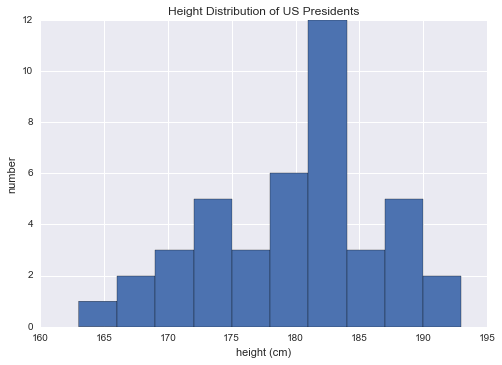

In [18]:
plt.hist(heights)
plt.title('Height Distribution of US Presidents')
plt.xlabel('height (cm)')
plt.ylabel('number');

These aggregates are some of the fundamental pieces of exploratory data analysis that we'll explore in more depth in later chapters of the book.

<!--NAVIGATION-->
< [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) | [Contents](Index.ipynb) | [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.04-Computation-on-arrays-aggregates.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb) | [Contents](Index.ipynb) | [Comparisons, Masks, and Boolean Logic](02.06-Boolean-Arrays-and-Masks.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.05-Computation-on-arrays-broadcasting.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Computation on Arrays: Broadcasting

We saw in the previous section how NumPy's universal functions can be used to *vectorize* operations and thereby remove slow Python loops.
Another means of vectorizing operations is to use NumPy's *broadcasting* functionality.
Broadcasting is simply a set of rules for applying binary ufuncs (e.g., addition, subtraction, multiplication, etc.) on arrays of different sizes.

## Introducing Broadcasting

Recall that for arrays of the same size, binary operations are performed on an element-by-element basis:

In [1]:
import numpy as np

In [2]:
a = np.array([0, 1, 2])
b = np.array([5, 5, 5])
a + b

array([5, 6, 7])

Broadcasting allows these types of binary operations to be performed on arrays of different sizes–for example, we can just as easily add a scalar (think of it as a zero-dimensional array) to an array:

In [3]:
a + 5

array([5, 6, 7])

We can think of this as an operation that stretches or duplicates the value ``5`` into the array ``[5, 5, 5]``, and adds the results.
The advantage of NumPy's broadcasting is that this duplication of values does not actually take place, but it is a useful mental model as we think about broadcasting.

We can similarly extend this to arrays of higher dimension. Observe the result when we add a one-dimensional array to a two-dimensional array:

In [4]:
M = np.ones((3, 3))
M

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

In [5]:
M + a

array([[ 1.,  2.,  3.],
       [ 1.,  2.,  3.],
       [ 1.,  2.,  3.]])

Here the one-dimensional array ``a`` is stretched, or broadcast across the second dimension in order to match the shape of ``M``.

While these examples are relatively easy to understand, more complicated cases can involve broadcasting of both arrays. Consider the following example:

In [6]:
a = np.arange(3)
b = np.arange(3)[:, np.newaxis]

print(a)
print(b)

[0 1 2]
[[0]
 [1]
 [2]]


In [7]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

Just as before we stretched or broadcasted one value to match the shape of the other, here we've stretched *both* ``a`` and ``b`` to match a common shape, and the result is a two-dimensional array!
The geometry of these examples is visualized in the following figure (Code to produce this plot can be found in the [appendix](06.00-Figure-Code.ipynb#Broadcasting), and is adapted from source published in the [astroML](http://astroml.org) documentation. Used by permission).

![Broadcasting Visual](figures/02.05-broadcasting.png)

The light boxes represent the broadcasted values: again, this extra memory is not actually allocated in the course of the operation, but it can be useful conceptually to imagine that it is.

## Rules of Broadcasting

Broadcasting in NumPy follows a strict set of rules to determine the interaction between the two arrays:

- Rule 1: If the two arrays differ in their number of dimensions, the shape of the one with fewer dimensions is *padded* with ones on its leading (left) side.
- Rule 2: If the shape of the two arrays does not match in any dimension, the array with shape equal to 1 in that dimension is stretched to match the other shape.
- Rule 3: If in any dimension the sizes disagree and neither is equal to 1, an error is raised.

To make these rules clear, let's consider a few examples in detail.

### Broadcasting example 1

Let's look at adding a two-dimensional array to a one-dimensional array:

In [8]:
M = np.ones((2, 3))
a = np.arange(3)

Let's consider an operation on these two arrays. The shape of the arrays are

- ``M.shape = (2, 3)``
- ``a.shape = (3,)``

We see by rule 1 that the array ``a`` has fewer dimensions, so we pad it on the left with ones:

- ``M.shape -> (2, 3)``
- ``a.shape -> (1, 3)``

By rule 2, we now see that the first dimension disagrees, so we stretch this dimension to match:

- ``M.shape -> (2, 3)``
- ``a.shape -> (2, 3)``

The shapes match, and we see that the final shape will be ``(2, 3)``:

In [9]:
M + a

array([[ 1.,  2.,  3.],
       [ 1.,  2.,  3.]])

### Broadcasting example 2

Let's take a look at an example where both arrays need to be broadcast:

In [10]:
a = np.arange(3).reshape((3, 1))
b = np.arange(3)

Again, we'll start by writing out the shape of the arrays:

- ``a.shape = (3, 1)``
- ``b.shape = (3,)``

Rule 1 says we must pad the shape of ``b`` with ones:

- ``a.shape -> (3, 1)``
- ``b.shape -> (1, 3)``

And rule 2 tells us that we upgrade each of these ones to match the corresponding size of the other array:

- ``a.shape -> (3, 3)``
- ``b.shape -> (3, 3)``

Because the result matches, these shapes are compatible. We can see this here:

In [11]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

### Broadcasting example 3

Now let's take a look at an example in which the two arrays are not compatible:

In [12]:
M = np.ones((3, 2))
a = np.arange(3)

This is just a slightly different situation than in the first example: the matrix ``M`` is transposed.
How does this affect the calculation? The shape of the arrays are

- ``M.shape = (3, 2)``
- ``a.shape = (3,)``

Again, rule 1 tells us that we must pad the shape of ``a`` with ones:

- ``M.shape -> (3, 2)``
- ``a.shape -> (1, 3)``

By rule 2, the first dimension of ``a`` is stretched to match that of ``M``:

- ``M.shape -> (3, 2)``
- ``a.shape -> (3, 3)``

Now we hit rule 3–the final shapes do not match, so these two arrays are incompatible, as we can observe by attempting this operation:

In [13]:
M + a

ValueError: operands could not be broadcast together with shapes (3,2) (3,) 

Note the potential confusion here: you could imagine making ``a`` and ``M`` compatible by, say, padding ``a``'s shape with ones on the right rather than the left.
But this is not how the broadcasting rules work!
That sort of flexibility might be useful in some cases, but it would lead to potential areas of ambiguity.
If right-side padding is what you'd like, you can do this explicitly by reshaping the array (we'll use the ``np.newaxis`` keyword introduced in [The Basics of NumPy Arrays](02.02-The-Basics-Of-NumPy-Arrays.ipynb)):

In [14]:
a[:, np.newaxis].shape

(3, 1)

In [15]:
M + a[:, np.newaxis]

array([[ 1.,  1.],
       [ 2.,  2.],
       [ 3.,  3.]])

Also note that while we've been focusing on the ``+`` operator here, these broadcasting rules apply to *any* binary ``ufunc``.
For example, here is the ``logaddexp(a, b)`` function, which computes ``log(exp(a) + exp(b))`` with more precision than the naive approach:

In [16]:
np.logaddexp(M, a[:, np.newaxis])

array([[ 1.31326169,  1.31326169],
       [ 1.69314718,  1.69314718],
       [ 2.31326169,  2.31326169]])

For more information on the many available universal functions, refer to [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb).

## Broadcasting in Practice

Broadcasting operations form the core of many examples we'll see throughout this book.
We'll now take a look at a couple simple examples of where they can be useful.

### Centering an array

In the previous section, we saw that ufuncs allow a NumPy user to remove the need to explicitly write slow Python loops. Broadcasting extends this ability.
One commonly seen example is when centering an array of data.
Imagine you have an array of 10 observations, each of which consists of 3 values.
Using the standard convention (see [Data Representation in Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb#Data-Representation-in-Scikit-Learn)), we'll store this in a $10 \times 3$ array:

In [17]:
X = np.random.random((10, 3))

We can compute the mean of each feature using the ``mean`` aggregate across the first dimension:

In [18]:
Xmean = X.mean(0)
Xmean

array([ 0.53514715,  0.66567217,  0.44385899])

And now we can center the ``X`` array by subtracting the mean (this is a broadcasting operation):

In [19]:
X_centered = X - Xmean

To double-check that we've done this correctly, we can check that the centered array has near zero mean:

In [20]:
X_centered.mean(0)

array([  2.22044605e-17,  -7.77156117e-17,  -1.66533454e-17])

To within machine precision, the mean is now zero.

### Plotting a two-dimensional function

One place that broadcasting is very useful is in displaying images based on two-dimensional functions.
If we want to define a function $z = f(x, y)$, broadcasting can be used to compute the function across the grid:

In [21]:
# x and y have 50 steps from 0 to 5
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 50)[:, np.newaxis]

z = np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)

We'll use Matplotlib to plot this two-dimensional array (these tools will be discussed in full in [Density and Contour Plots](04.04-Density-and-Contour-Plots.ipynb)):

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

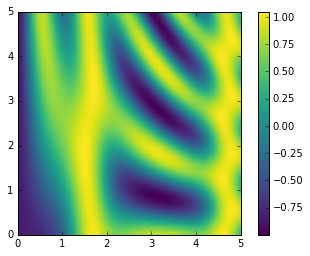

In [23]:
plt.imshow(z, origin='lower', extent=[0, 5, 0, 5],
           cmap='viridis')
plt.colorbar();

The result is a compelling visualization of the two-dimensional function.

<!--NAVIGATION-->
< [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb) | [Contents](Index.ipynb) | [Comparisons, Masks, and Boolean Logic](02.06-Boolean-Arrays-and-Masks.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.05-Computation-on-arrays-broadcasting.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb) | [Contents](Index.ipynb) | [Fancy Indexing](02.07-Fancy-Indexing.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.06-Boolean-Arrays-and-Masks.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Comparisons, Masks, and Boolean Logic

This section covers the use of Boolean masks to examine and manipulate values within NumPy arrays.
Masking comes up when you want to extract, modify, count, or otherwise manipulate values in an array based on some criterion: for example, you might wish to count all values greater than a certain value, or perhaps remove all outliers that are above some threshold.
In NumPy, Boolean masking is often the most efficient way to accomplish these types of tasks.

## Example: Counting Rainy Days

Imagine you have a series of data that represents the amount of precipitation each day for a year in a given city.
For example, here we'll load the daily rainfall statistics for the city of Seattle in 2014, using Pandas (which is covered in more detail in [Chapter 3](03.00-Introduction-to-Pandas.ipynb)):

In [1]:
import numpy as np
import pandas as pd

# use pandas to extract rainfall inches as a NumPy array
rainfall = pd.read_csv('data/Seattle2014.csv')['PRCP'].values
inches = rainfall / 254.0  # 1/10mm -> inches
inches.shape

(365,)

The array contains 365 values, giving daily rainfall in inches from January 1 to December 31, 2014.

As a first quick visualization, let's look at the histogram of rainy days, which was generated using Matplotlib (we will explore this tool more fully in [Chapter 4](04.00-Introduction-To-Matplotlib.ipynb)):

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # set plot styles

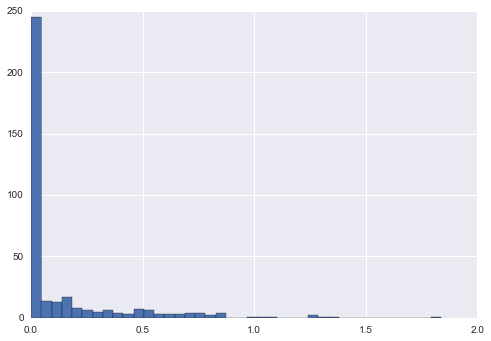

In [3]:
plt.hist(inches, 40);

This histogram gives us a general idea of what the data looks like: despite its reputation, the vast majority of days in Seattle saw near zero measured rainfall in 2014.
But this doesn't do a good job of conveying some information we'd like to see: for example, how many rainy days were there in the year? What is the average precipitation on those rainy days? How many days were there with more than half an inch of rain?

### Digging into the data

One approach to this would be to answer these questions by hand: loop through the data, incrementing a counter each time we see values in some desired range.
For reasons discussed throughout this chapter, such an approach is very inefficient, both from the standpoint of time writing code and time computing the result.
We saw in [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) that NumPy's ufuncs can be used in place of loops to do fast element-wise arithmetic operations on arrays; in the same way, we can use other ufuncs to do element-wise *comparisons* over arrays, and we can then manipulate the results to answer the questions we have.
We'll leave the data aside for right now, and discuss some general tools in NumPy to use *masking* to quickly answer these types of questions.

## Comparison Operators as ufuncs

In [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) we introduced ufuncs, and focused in particular on arithmetic operators. We saw that using ``+``, ``-``, ``*``, ``/``, and others on arrays leads to element-wise operations.
NumPy also implements comparison operators such as ``<`` (less than) and ``>`` (greater than) as element-wise ufuncs.
The result of these comparison operators is always an array with a Boolean data type.
All six of the standard comparison operations are available:

In [4]:
x = np.array([1, 2, 3, 4, 5])

In [5]:
x < 3  # less than

array([ True,  True, False, False, False], dtype=bool)

In [6]:
x > 3  # greater than

array([False, False, False,  True,  True], dtype=bool)

In [7]:
x <= 3  # less than or equal

array([ True,  True,  True, False, False], dtype=bool)

In [8]:
x >= 3  # greater than or equal

array([False, False,  True,  True,  True], dtype=bool)

In [9]:
x != 3  # not equal

array([ True,  True, False,  True,  True], dtype=bool)

In [10]:
x == 3  # equal

array([False, False,  True, False, False], dtype=bool)

It is also possible to do an element-wise comparison of two arrays, and to include compound expressions:

In [11]:
(2 * x) == (x ** 2)

array([False,  True, False, False, False], dtype=bool)

As in the case of arithmetic operators, the comparison operators are implemented as ufuncs in NumPy; for example, when you write ``x < 3``, internally NumPy uses ``np.less(x, 3)``.
    A summary of the comparison operators and their equivalent ufunc is shown here:

| Operator	    | Equivalent ufunc    || Operator	   | Equivalent ufunc    |
|---------------|---------------------||---------------|---------------------|
|``==``         |``np.equal``         ||``!=``         |``np.not_equal``     |
|``<``          |``np.less``          ||``<=``         |``np.less_equal``    |
|``>``          |``np.greater``       ||``>=``         |``np.greater_equal`` |

Just as in the case of arithmetic ufuncs, these will work on arrays of any size and shape.
Here is a two-dimensional example:

In [12]:
rng = np.random.RandomState(0)
x = rng.randint(10, size=(3, 4))
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

In [13]:
x < 6

array([[ True,  True,  True,  True],
       [False, False,  True,  True],
       [ True,  True, False, False]], dtype=bool)

In each case, the result is a Boolean array, and NumPy provides a number of straightforward patterns for working with these Boolean results.

## Working with Boolean Arrays

Given a Boolean array, there are a host of useful operations you can do.
We'll work with ``x``, the two-dimensional array we created earlier.

In [14]:
print(x)

[[5 0 3 3]
 [7 9 3 5]
 [2 4 7 6]]


### Counting entries

To count the number of ``True`` entries in a Boolean array, ``np.count_nonzero`` is useful:

In [15]:
# how many values less than 6?
np.count_nonzero(x < 6)

8

We see that there are eight array entries that are less than 6.
Another way to get at this information is to use ``np.sum``; in this case, ``False`` is interpreted as ``0``, and ``True`` is interpreted as ``1``:

In [16]:
np.sum(x < 6)

8

The benefit of ``sum()`` is that like with other NumPy aggregation functions, this summation can be done along rows or columns as well:

In [17]:
# how many values less than 6 in each row?
np.sum(x < 6, axis=1)

array([4, 2, 2])

This counts the number of values less than 6 in each row of the matrix.

If we're interested in quickly checking whether any or all the values are true, we can use (you guessed it) ``np.any`` or ``np.all``:

In [18]:
# are there any values greater than 8?
np.any(x > 8)

True

In [19]:
# are there any values less than zero?
np.any(x < 0)

False

In [20]:
# are all values less than 10?
np.all(x < 10)

True

In [21]:
# are all values equal to 6?
np.all(x == 6)

False

``np.all`` and ``np.any`` can be used along particular axes as well. For example:

In [22]:
# are all values in each row less than 8?
np.all(x < 8, axis=1)

array([ True, False,  True], dtype=bool)

Here all the elements in the first and third rows are less than 8, while this is not the case for the second row.

Finally, a quick warning: as mentioned in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb), Python has built-in ``sum()``, ``any()``, and ``all()`` functions. These have a different syntax than the NumPy versions, and in particular will fail or produce unintended results when used on multidimensional arrays. Be sure that you are using ``np.sum()``, ``np.any()``, and ``np.all()`` for these examples!

### Boolean operators

We've already seen how we might count, say, all days with rain less than four inches, or all days with rain greater than two inches.
But what if we want to know about all days with rain less than four inches and greater than one inch?
This is accomplished through Python's *bitwise logic operators*, ``&``, ``|``, ``^``, and ``~``.
Like with the standard arithmetic operators, NumPy overloads these as ufuncs which work element-wise on (usually Boolean) arrays.

For example, we can address this sort of compound question as follows:

In [23]:
np.sum((inches > 0.5) & (inches < 1))

29

So we see that there are 29 days with rainfall between 0.5 and 1.0 inches.

Note that the parentheses here are important–because of operator precedence rules, with parentheses removed this expression would be evaluated as follows, which results in an error:

``` python
inches > (0.5 & inches) < 1
```

Using the equivalence of *A AND B* and *NOT (NOT A OR NOT B)* (which you may remember if you've taken an introductory logic course), we can compute the same result in a different manner:

In [24]:
np.sum(~( (inches <= 0.5) | (inches >= 1) ))

29

Combining comparison operators and Boolean operators on arrays can lead to a wide range of efficient logical operations.

The following table summarizes the bitwise Boolean operators and their equivalent ufuncs:

| Operator	    | Equivalent ufunc    || Operator	    | Equivalent ufunc    |
|---------------|---------------------||---------------|---------------------|
|``&``          |``np.bitwise_and``   ||&#124;         |``np.bitwise_or``    |
|``^``          |``np.bitwise_xor``   ||``~``          |``np.bitwise_not``   |

Using these tools, we might start to answer the types of questions we have about our weather data.
Here are some examples of results we can compute when combining masking with aggregations:

In [25]:
print("Number days without rain:      ", np.sum(inches == 0))
print("Number days with rain:         ", np.sum(inches != 0))
print("Days with more than 0.5 inches:", np.sum(inches > 0.5))
print("Rainy days with < 0.2 inches  :", np.sum((inches > 0) &
                                                (inches < 0.2)))

Number days without rain:       215
Number days with rain:          150
Days with more than 0.5 inches: 37
Rainy days with < 0.2 inches  : 75


## Boolean Arrays as Masks

In the preceding section we looked at aggregates computed directly on Boolean arrays.
A more powerful pattern is to use Boolean arrays as masks, to select particular subsets of the data themselves.
Returning to our ``x`` array from before, suppose we want an array of all values in the array that are less than, say, 5:

In [26]:
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

We can obtain a Boolean array for this condition easily, as we've already seen:

In [27]:
x < 5

array([[False,  True,  True,  True],
       [False, False,  True, False],
       [ True,  True, False, False]], dtype=bool)

Now to *select* these values from the array, we can simply index on this Boolean array; this is known as a *masking* operation:

In [28]:
x[x < 5]

array([0, 3, 3, 3, 2, 4])

What is returned is a one-dimensional array filled with all the values that meet this condition; in other words, all the values in positions at which the mask array is ``True``.

We are then free to operate on these values as we wish.
For example, we can compute some relevant statistics on our Seattle rain data:

In [29]:
# construct a mask of all rainy days
rainy = (inches > 0)

# construct a mask of all summer days (June 21st is the 172nd day)
days = np.arange(365)
summer = (days > 172) & (days < 262)

print("Median precip on rainy days in 2014 (inches):   ",
      np.median(inches[rainy]))
print("Median precip on summer days in 2014 (inches):  ",
      np.median(inches[summer]))
print("Maximum precip on summer days in 2014 (inches): ",
      np.max(inches[summer]))
print("Median precip on non-summer rainy days (inches):",
      np.median(inches[rainy & ~summer]))

Median precip on rainy days in 2014 (inches):    0.194881889764
Median precip on summer days in 2014 (inches):   0.0
Maximum precip on summer days in 2014 (inches):  0.850393700787
Median precip on non-summer rainy days (inches): 0.200787401575


By combining Boolean operations, masking operations, and aggregates, we can very quickly answer these sorts of questions for our dataset.

## Aside: Using the Keywords and/or Versus the Operators &/|

One common point of confusion is the difference between the keywords ``and`` and ``or`` on one hand, and the operators ``&`` and ``|`` on the other hand.
When would you use one versus the other?

The difference is this: ``and`` and ``or`` gauge the truth or falsehood of *entire object*, while ``&`` and ``|`` refer to *bits within each object*.

When you use ``and`` or ``or``, it's equivalent to asking Python to treat the object as a single Boolean entity.
In Python, all nonzero integers will evaluate as True. Thus:

In [30]:
bool(42), bool(0)

(True, False)

In [31]:
bool(42 and 0)

False

In [32]:
bool(42 or 0)

True

When you use ``&`` and ``|`` on integers, the expression operates on the bits of the element, applying the *and* or the *or* to the individual bits making up the number:

In [33]:
bin(42)

'0b101010'

In [34]:
bin(59)

'0b111011'

In [35]:
bin(42 & 59)

'0b101010'

In [36]:
bin(42 | 59)

'0b111011'

Notice that the corresponding bits of the binary representation are compared in order to yield the result.

When you have an array of Boolean values in NumPy, this can be thought of as a string of bits where ``1 = True`` and ``0 = False``, and the result of ``&`` and ``|`` operates similarly to above:

In [37]:
A = np.array([1, 0, 1, 0, 1, 0], dtype=bool)
B = np.array([1, 1, 1, 0, 1, 1], dtype=bool)
A | B

array([ True,  True,  True, False,  True,  True], dtype=bool)

Using ``or`` on these arrays will try to evaluate the truth or falsehood of the entire array object, which is not a well-defined value:

In [38]:
A or B

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Similarly, when doing a Boolean expression on a given array, you should use ``|`` or ``&`` rather than ``or`` or ``and``:

In [39]:
x = np.arange(10)
(x > 4) & (x < 8)

array([False, False, False, False, False,  True,  True,  True, False, False], dtype=bool)

Trying to evaluate the truth or falsehood of the entire array will give the same ``ValueError`` we saw previously:

In [40]:
(x > 4) and (x < 8)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

So remember this: ``and`` and ``or`` perform a single Boolean evaluation on an entire object, while ``&`` and ``|`` perform multiple Boolean evaluations on the content (the individual bits or bytes) of an object.
For Boolean NumPy arrays, the latter is nearly always the desired operation.

<!--NAVIGATION-->
< [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb) | [Contents](Index.ipynb) | [Fancy Indexing](02.07-Fancy-Indexing.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.06-Boolean-Arrays-and-Masks.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
